# Neural Networks Project - Gesture Recognition

- This project involves building a 3D Convolutional Neural Network to correctly recognize hand gestures by a user to control a smart TV.

- The objective of this projects is to build a hand gesture recognition model that can be hosted on a camera installed in a smart TV that can understand 5 gestures.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command.

- Thumbs up: Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds
- Stop: Pause the movie

**Understanding the Dataset:**

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

### Importing all the necessary libraries

In [ ]:
#import the necessary libraries
import numpy as np
import os
import imageio.v2 as imageio
from skimage.transform import resize
from PIL import Image
import datetime
import os
import matplotlib.pyplot as plt

In [ ]:
from keras import backend as K
import tensorflow as tf
import random as rn

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten,Dropout, TimeDistributed, Flatten, BatchNormalization, Activation,Conv3D, GlobalAveragePooling3D, MaxPooling3D,MaxPooling2D, GlobalAveragePooling2D,ConvLSTM2D,Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

### Reading the data

In [ ]:
# We set the random seed so that the results don't vary drastically.
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('/Users/sindhujav/Downloads/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/Users/sindhujav/Downloads/Project_data/val.csv').readlines())
batch_size = 25
frame_width =100
frame_height =100
no_of_channels=3
sequence_idx = range(7,26,2)
input_shape=(len(sequence_idx),frame_width,frame_height,no_of_channels)

### Generator code
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = sequence_idx
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data, batch_labels= one_batch_of_data(source_path,t,batch,batch_size,img_idx)
            yield batch_data, batch_labels

            remaining_sequence=len(t)%batch_size

            if (remaining_sequence != 0):
                batch_data, batch_labels= one_batch_of_data(source_path,t,num_batches,batch_size,img_idx,remaining_sequence)
                yield batch_data, batch_labels



def one_batch_of_data(source_path,t,batch,batch_size,img_idx,remaining_sequence=0):
    sequence_length = remaining_sequence if remaining_sequence else batch_size

    batch_data = np.zeros((sequence_length,len(img_idx),frame_width,frame_height,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((sequence_length,5)) # batch_labels is the one hot representation of the output

    for folder in range(sequence_length): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #cropping the image
            if image.shape[1] > image.shape[0]:
               diff_px = image.shape[1] - image.shape[0]
               crop_start = diff_px//2
               crop_end = crop_start + image.shape[0]
               image = image[:, crop_start:crop_end]
            elif image.shape[0] > image.shape[1]:
                 diff_px = image.shape[0] - image.shape[1]
                 crop_start = diff_px//2
                 crop_end = crop_start + image.shape[1]
                 image = image[:, crop_start:crop_end]

            #resizing the image
            image_resized=resize(image,(frame_width,frame_height,3))

            #normalizing the image
            batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the R channel image
            batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the G channel image
            batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the B channel image

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return(batch_data, batch_labels)


### Defining train and validation folder paths, epoch , model checkpoint and creating train and validation generators

In [ ]:
# defining train and validation folder paths, epoch and creating train and validation generators
curr_dt_time = datetime.datetime.now()
train_path = '/Users/sindhujav/Downloads/Project_data/train'
val_path = '/Users/sindhujav/Downloads/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40
print ('# epochs =', num_epochs)


train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
batch_data, batch_labels=next(val_generator)

# defining model checkpoint
filepath = 'models/best_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]


#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 663
# validation sequences = 100
# epochs = 40
Source path =  /Users/sindhujav/Downloads/Project_data/val ; batch size = 25


### Model Creation

#### Model 1 conv3D

In [ ]:
#this model is created basic number of layers
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

NameError: name 'Sequential' is not defined

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

NameError: name 'model' is not defined

In [ ]:
# Plotting model accuracy and model loss for train and validation data
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

##### Model 1 observation

From this model, we can observe that
- Train set Accuracy: 18.2 %
- Test set Accuracy: 22.2 %

We can observe that there is underfitting caused in this model and can be improved by adding different layers with with different number of neurons i.e., Hyperparameters tuning

#### Model 2 conv 3D

In [ ]:
#this model is created with increased number of layers and with more number of neurons
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)               │ (None, 8, 98, 98, 32)  │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 6, 96, 96, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 3, 48, 48, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 1, 46, 46, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 1, 23, 23, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 1, 21, 21, 256) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 1, 10, 10, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 1, 8, 8, 512)   │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 1, 6, 6, 512)   │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 1, 3, 3, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,476,805 (24.71 MB)

 Trainable params: 6,476,805 (24.71 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/50

Epoch 1: saving model to models/best_model.keras
 1/21 ━━━━━━━━━━━━━━━━━━━━ 2:35 8s/step - categorical_accuracy: 0.2500 - loss: 1.6061
Epoch 1: saving model to models/best_model.keras
 2/21 ━━━━━━━━━━━━━━━━━━━━ 1:28 5s/step - categorical_accuracy: 0.2250 - loss: 11004.3115
Epoch 1: saving model to models/best_model.keras
 3/21 ━━━━━━━━━━━━━━━━━━━━ 1:41 6s/step - categorical_accuracy: 0.2228 - loss: 11976.6152
Epoch 1: saving model to models/best_model.keras
 4/21 ━━━━━━━━━━━━━━━━━━━━ 1:30 5s/step - categorical_accuracy: 0.2285 - loss: 11735.2812
Epoch 1: saving model to models/best_model.keras
 5/21 ━━━━━━━━━━━━━━━━━━━━ 1:30 6s/step - categorical_accuracy: 0.2321 - loss: 11115.5576
Epoch 1: saving model to models/best_model.keras
 6/21 ━━━━━━━━━━━━━━━━━━━━ 1:21 5s/step - categorical_accuracy: 0.2378 - loss: 10502.4619
Epoch 1: saving model to models/best_model.keras
 7/21 ━━━━━━━━━━━━━━━━━━━━ 1:18 6s/step - categorical_accuracy: 0.2394 - loss: 9892.0811 
Epoch 1: saving mod

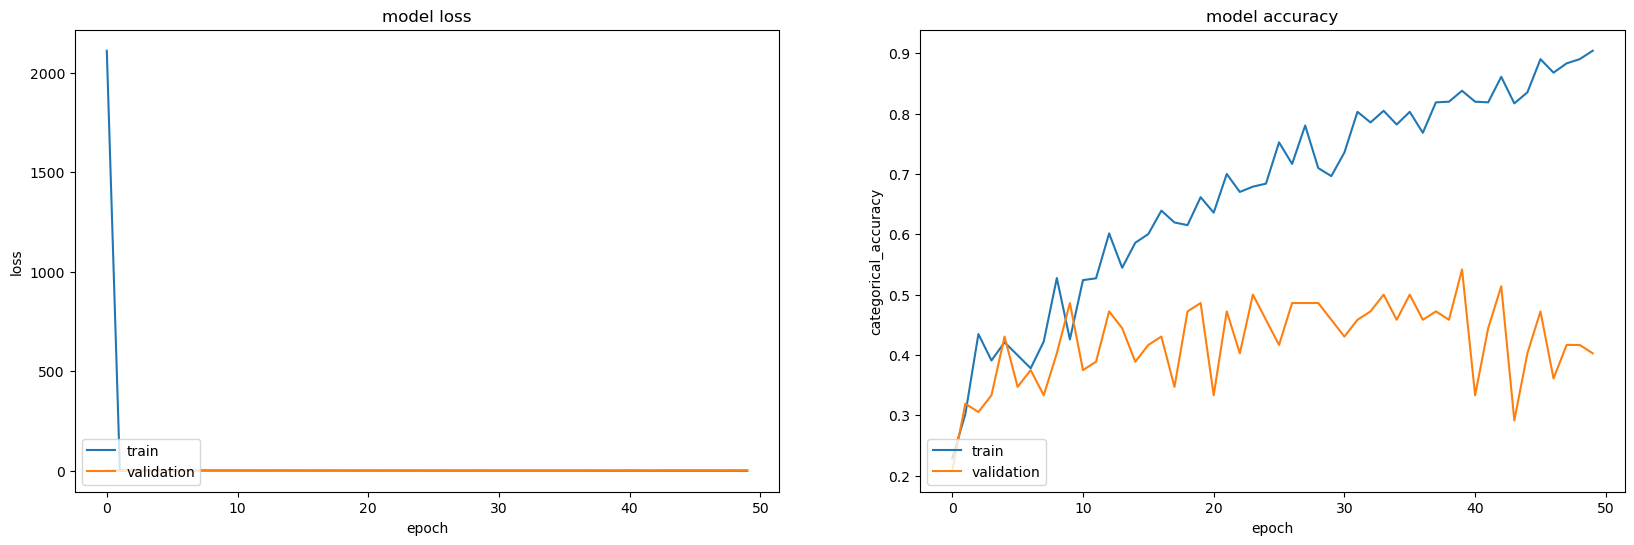

In [ ]:
# Plotting model accuracy and model loss for train and validation data
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

##### Model 2 observation

From this model, we can observe that
- Train set Accuracy: 86.7 %
- Test set Accuracy: 40.2 %

As there is a long gap between the accuracies which is nothing but overfitting, so we can try with other different parameters

#### Model 3 conv3D

In [ ]:
#this model is created with increased number of layers and with more number of neurons
#also we have added batch normalization and dropout layers for better accuracies
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_10 (Conv3D)              │ (None, 8, 98, 98, 32)  │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 6, 96, 96, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 3, 48, 48, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 48, 48, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 48, 48, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_12 (Conv3D)              │ (None, 1, 46, 46, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 1, 23, 23, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 23, 23, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 23, 23, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_13 (Conv3D)              │ (None, 1, 21, 21, 256) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 1, 10, 10, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 10, 10, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 10, 10, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,688,581 (52.22 MB)

 Trainable params: 13,686,661 (52.21 MB)

 Non-trainable params: 1,920 (7.50 KB)

None


In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/50

Epoch 1: saving model to models/best_model.keras
 1/21 ━━━━━━━━━━━━━━━━━━━━ 2:02 6s/step - categorical_accuracy: 0.2174 - loss: 2.3095
Epoch 1: saving model to models/best_model.keras
 2/21 ━━━━━━━━━━━━━━━━━━━━ 2:06 7s/step - categorical_accuracy: 0.1996 - loss: 3.9844
Epoch 1: saving model to models/best_model.keras
 3/21 ━━━━━━━━━━━━━━━━━━━━ 1:43 6s/step - categorical_accuracy: 0.2399 - loss: 4.2279
Epoch 1: saving model to models/best_model.keras
 4/21 ━━━━━━━━━━━━━━━━━━━━ 1:42 6s/step - categorical_accuracy: 0.2549 - loss: 4.4165
Epoch 1: saving model to models/best_model.keras
 5/21 ━━━━━━━━━━━━━━━━━━━━ 1:31 6s/step - categorical_accuracy: 0.2867 - loss: 4.3630
Epoch 1: saving model to models/best_model.keras
 6/21 ━━━━━━━━━━━━━━━━━━━━ 1:28 6s/step - categorical_accuracy: 0.3086 - loss: 4.2884
Epoch 1: saving model to models/best_model.keras
 7/21 ━━━━━━━━━━━━━━━━━━━━ 1:19 6s/step - categorical_accuracy: 0.3344 - loss: 4.1681
Epoch 1: saving model to models/best_model.

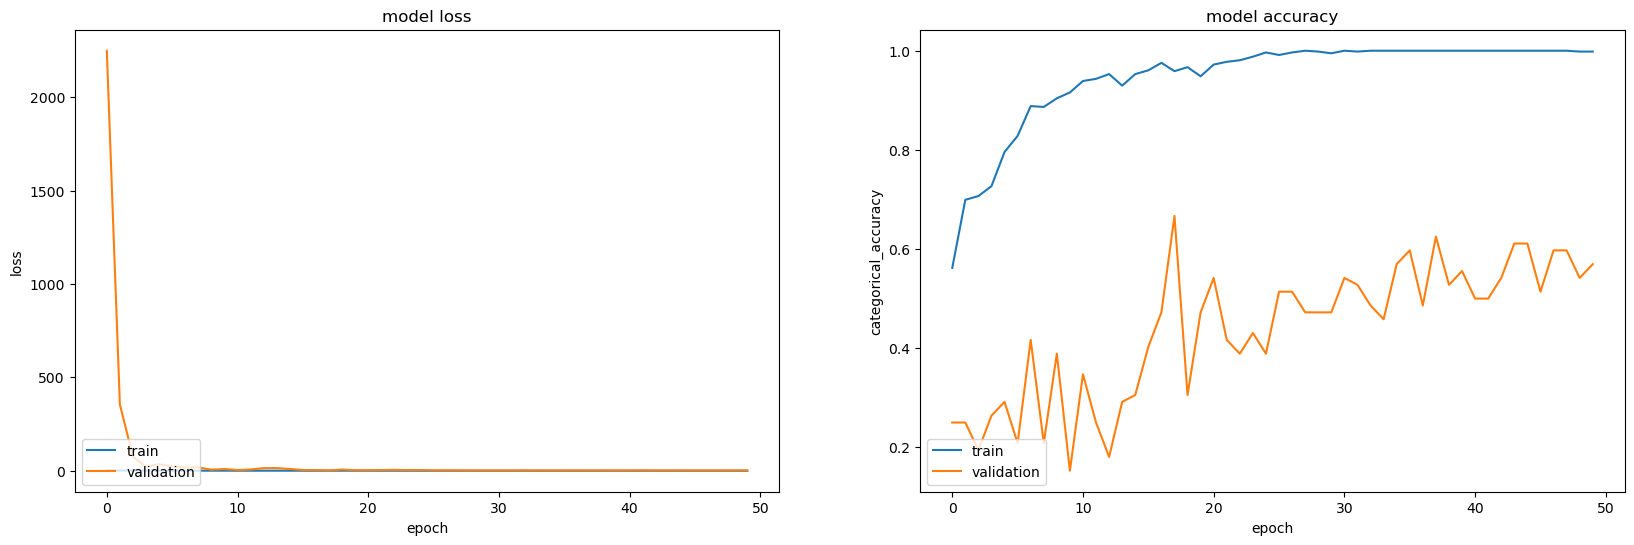

In [ ]:
# Plotting model accuracy and model loss for train and validation data
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

##### Model 3 observation

From this model, we can observe that
- Train set Accuracy: 99.8 %
- Test set Accuracy: 56.9 %

As there is a long gap between the accuracies which is nothing but overfitting, so we can try with other different parameters

#### Model 4 conv2D Time distributed

In [ ]:
#this conv2D model is created with time distributed layer with batch normalization
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam(learning_rate=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 98, 98, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 49, 49, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 49, 49, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 47, 47, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 23, 23, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 23, 23, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 21, 21,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 10, 10,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 10, 10, 10,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,477 (505.77 KB)

 Trainable params: 128,517 (502.02 KB)

 Non-trainable params: 960 (3.75 KB)

None


In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/50

Epoch 1: saving model to models/best_model.keras
 1/21 ━━━━━━━━━━━━━━━━━━━━ 1:26 4s/step - categorical_accuracy: 0.1875 - loss: 2.2644
Epoch 1: saving model to models/best_model.keras
 2/21 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - categorical_accuracy: 0.2119 - loss: 2.2481 
Epoch 1: saving model to models/best_model.keras
 3/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - categorical_accuracy: 0.2371 - loss: 2.2911
Epoch 1: saving model to models/best_model.keras
 4/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - categorical_accuracy: 0.2596 - loss: 2.3167
Epoch 1: saving model to models/best_model.keras
 5/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - categorical_accuracy: 0.2697 - loss: 2.3413
Epoch 1: saving model to models/best_model.keras
 6/21 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - categorical_accuracy: 0.2843 - loss: 2.3187
Epoch 1: saving model to models/best_model.keras
 7/21 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - categorical_accuracy: 0.2937 - loss: 2.2962
Epoch 1: saving model to models/best_model.keras

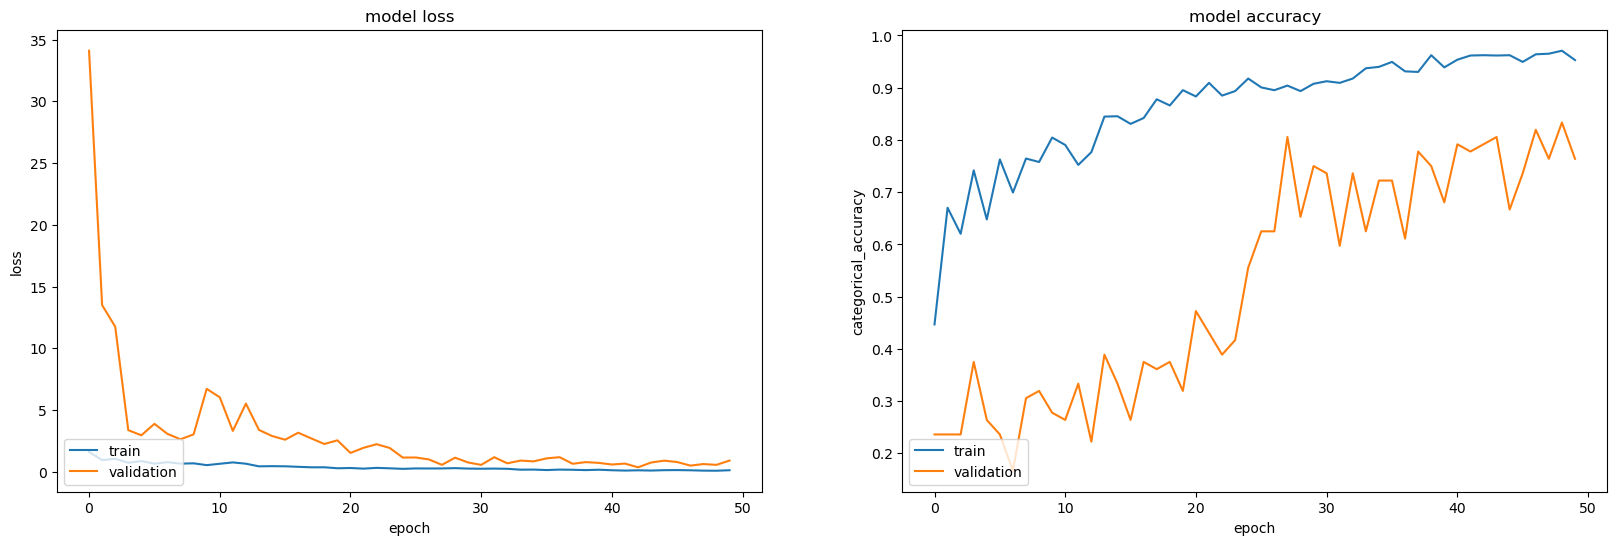

In [ ]:
# Plotting model accuracy and model loss for train and validation data
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

##### Model 4 observation

From this model, we can observe that
- Train set Accuracy: 97.1 %
- Test set Accuracy: 76.3 %

This time the model gave the better results than the previous one because of adding time distributed layer with conv2D model but not the best

#### Model 5 conv2D LSTM

In [ ]:
#this conv2D LSTM model is created with time distributed layer with batch normalization
#by decreasing the number of neurons i.e., by reducing epochs = early stopping
model = Sequential()
model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model.add(BatchNormalization())
model.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
model.add(BatchNormalization())
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ (None, 10, 98, 98, 8)  │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 10, 98, 98, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 96, 96, 16) │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 96, 96, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 94, 94, 8)      │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 94, 94, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 94, 94, 64)     │           576 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 94, 94, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,781 (53.83 KB)

 Trainable params: 13,589 (53.08 KB)

 Non-trainable params: 192 (768.00 B)

None


In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /Users/sindhujav/Downloads/Project_data/train ; batch size = 25
Epoch 1/40

Epoch 1: saving model to models/best_model.keras
 1/27 ━━━━━━━━━━━━━━━━━━━━ 1:56 4s/step - categorical_accuracy: 0.0800 - loss: 1.7187
Epoch 1: saving model to models/best_model.keras
 2/27 ━━━━━━━━━━━━━━━━━━━━ 21s 874ms/step - categorical_accuracy: 0.1058 - loss: 1.6886
Epoch 1: saving model to models/best_model.keras
 3/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - categorical_accuracy: 0.1446 - loss: 1.6523   
Epoch 1: saving model to models/best_model.keras
 4/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - categorical_accuracy: 0.1808 - loss: 1.6192
Epoch 1: saving model to models/best_model.keras
 5/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - categorical_accuracy: 0.2060 - loss: 1.5989
Epoch 1: saving model to models/best_model.keras
 6/27 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - categorical_accuracy: 0.2258 - loss: 1.5797
Epoch 1: saving model to models/best_model.keras
 7/27 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - categori

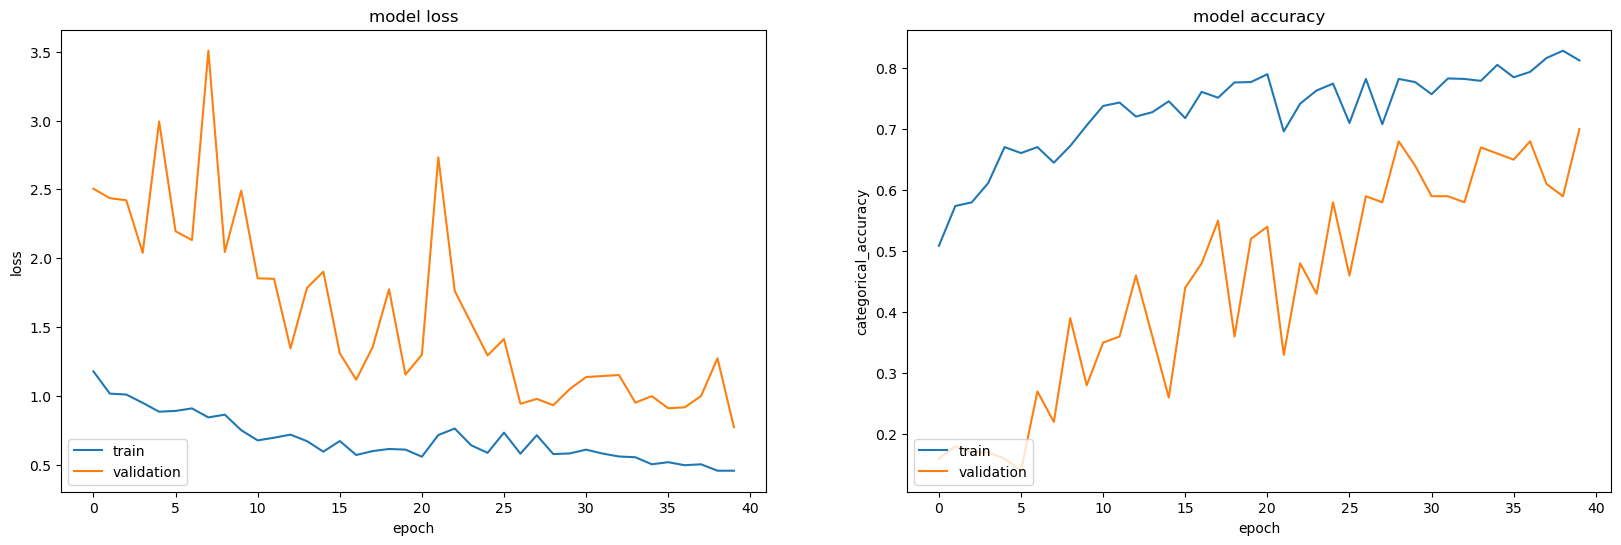

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

##### Model 5 observation

From this model, we can observe that
- Train set Accuracy: 80.1 %
- Test set Accuracy: 70.3 %

This time the model still gave the better results than the previous one because of adding time distributed layer with conv2D model as there is no such more difference

**We can conclude that this is the best model**

### Conclusion

The Model-5 is considered to be the best model i.e., conv2D with LSTM with good results.

This has completed training with decent and good accuracy of 80 % over validation data.
